In [1]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import datetime as dt
from difflib import get_close_matches
import matplotlib.pyplot as plt
from datetime import timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer

%matplotlib inline

/home/robmulla/miniconda3/envs/w266/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [8]:
good_data_games = pd.read_csv('../../data/Good_Games_with_DateGameNames.csv')
winpct = pd.read_csv('../../data/All_plays_Feb17.csv')
playbyplay = pd.read_csv('../../data/All_tweets_Feb17.csv')

In [12]:
good_data_games

,Unnamed: 0,Date,Thread Title,Thread ID,Thread Name,Number of Comments,Score,Subreddit,Unnamed: 8,Unnamed: 9,Unnamed: 10,Game and Date,matched_game_date
0,243,2017-10-30,Game Thread: Denver Broncos (3-3) at Kansas Ci...,79ruxo,t3_79ruxo,10700,444,nfl,822971.0,2202043.0,0.373731,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Broncos vs. Chiefs 2017-10-30
1,244,2017-12-17,Game Thread: Green Bay Packers (7-6) at Caroli...,7kf1if,t3_7kf1if,11147,498,nfl,834118.0,2202043.0,0.378793,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Packers vs. Panthers 2017-12-17
2,245,2017-12-10,Game Thread: Minnesota Vikings (10-2) at Carol...,7iv8pw,t3_7iv8pw,11201,558,nfl,845319.0,2202043.0,0.383879,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Vikings vs. Panthers 2017-12-10
3,247,2017-10-29,Game Thread: Pittsburgh Steelers (5-2) at Detr...,79k5lu,t3_79k5lu,11528,458,nfl,868081.0,2202043.0,0.394216,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Steelers vs. Lions 2017-10-29
4,248,2017-09-24,Game Thread: Oakland Raiders (2-0) at Washingt...,728u47,t3_728u47,11653,661,nfl,879734.0,2202043.0,0.399508,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Raiders vs. Redskins 2017-09-24
5,249,2017-12-23,Game Thread: Minnesota Vikings (11-3) at Green...,7lsa66,t3_7lsa66,11738,465,nfl,891472.0,2202043.0,0.404839,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Vikings vs. Packers 2017-12-23
6,250,2017-10-15,Game Thread: Green Bay Packers (4-1) at Minnes...,76jy1v,t3_76jy1v,12097,646,nfl,903569.0,2202043.0,0.410332,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Packers vs. Vikings 2017-10-15
7,252,2017-11-30,Game Thread: Washington Redskins (5-6) at Dall...,7gr8r5,t3_7gr8r5,12240,450,nfl,928038.0,2202043.0,0.421444,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Redskins vs. Cowboys 2017-11-30
8,253,2017-12-25,Game Thread: Oakland Raiders (6-8) at Philadel...,7m4qjj,t3_7m4qjj,12266,389,nfl,940304.0,2202043.0,0.427014,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Raiders vs. Eagles 2017-12-25
9,254,2017-11-06,Game Thread: Detroit Lions (3-4) at Green Bay ...,7b9o5g,t3_7b9o5g,12390,571,nfl,952694.0,2202043.0,0.432641,Denver Broncos (3-3) at Kansas City Chiefs (5-...,Lions vs. Packers 2017-11-06


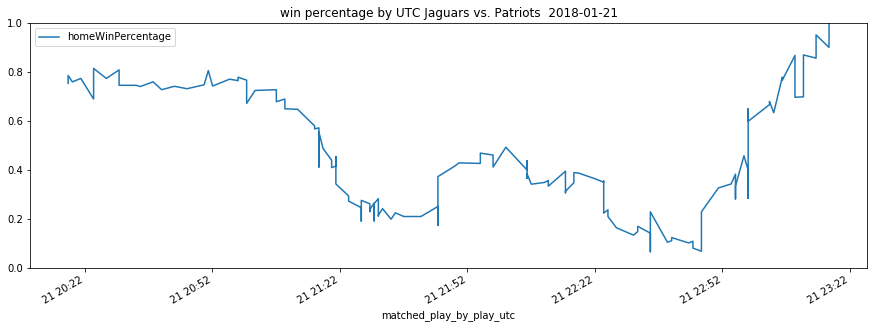

In [33]:
game = good_data_games.loc[35]['matched_game_date']
thread = good_data_games.loc[35]['Thread ID']
try:
    # filter win percentage 
    game_winpct = winpct.loc[winpct['Game Title Date'] == game].copy().reset_index()
    game_playbyplay = playbyplay.loc[playbyplay['Game Title Date'] == game].copy().reset_index()

    # Plot play by play to make sure it looks reasonible
    #game_playbyplay.plot('UTC_Datetime', y='tweet_id', figsize=(15,5), title='Tweets timeline : {}'.format(game))

    # Loop through win percent and match with play by play get UTC
    first_index = 0
    for i in game_winpct.iterrows():
        pbp_text = i[1]['text']
        # print(pbp_text)
        next_10_playbyplay = game_playbyplay['text_cleaned'][first_index:first_index+5]
        match = process.extractOne(pbp_text, next_10_playbyplay)
        # print(match)
        match_text, match_percent, match_index = match
        game_winpct.loc[i[0], 'matched_play_by_play_text'] = match_text
        game_winpct.loc[i[0], 'matched_play_by_play_index'] = match_index
        game_winpct.loc[i[0], 'matched_play_by_play_utc'] = game_playbyplay.loc[match_index]['UTC_Datetime']
        game_winpct.loc[i[0], 'matched_play_by_play_tweetid'] = game_playbyplay.loc[match_index]['tweet_id']
        first_index = match_index

    game_winpct['matched_play_by_play_utc'] = pd.to_datetime(game_winpct['matched_play_by_play_utc'])
    game_winpct.plot(x='matched_play_by_play_utc', y='homeWinPercentage', ylim=(0,1), figsize=(15,5), title='win percentage by UTC {}'.format(game))

    game_winpct['home_team'] = game_winpct.loc[0, 'Game Title Date'].split()[2]
    game_winpct['away_team'] = game_winpct.loc[0, 'Game Title Date'].split()[0]
    game_winpct['awayWinPercentage'] = 1 - game_winpct['homeWinPercentage']

    # Save to CSV
    filename = game.replace(' ','_').replace('.','') + '_UTCandWinPCT.csv'
    game_winpct.to_csv('../../data/Clean_Game_Data/' + filename)

    df = game_winpct.copy()
    df['UTC_Datetime'] = pd.to_datetime(df['matched_play_by_play_utc'])

    # Load Comments
    comments = pd.read_pickle('../../../data/{}_parsed_comments.pickle'.format(thread))
    comments = comments.sort_values('comment_created_utc_datetime')
    # Loop through comments

    only_greater = df.copy()

    playidlist = []

    for row in comments['comment_created_utc_datetime']:
        mytime = row + timedelta(hours=5)
        only_greater = only_greater.loc[df['UTC_Datetime'] >= mytime]
        try:
            playid_attime = only_greater.head(1)['playId'].values[0]
            playidlist.append(playid_attime)
        except:
            playidlist.append(playid_attime)

    comments['playId'] = playidlist
    merged = comments.merge(game_winpct, on='playId')

    # Calculate Sentiment
    sid = SentimentIntensityAnalyzer()

    def calculate_VADER(comment):
        comment = str(comment)
        ss = sid.polarity_scores(comment)
        neg = ss['neg']
        neu = ss['neu']
        pos = ss['pos']
        compound = ss['compound']
        return ss, neg, neu, pos, compound

    def vader_df(df, textcol = 'text'):
        df['vader_ss'], df['vader_neg'], df['vader_neu'], df['vader_pos'], df['vader_compound'] = \
        zip(*df[textcol].map(calculate_VADER))
        return df

    merged_with_sentiment = vader_df(merged, textcol='comment_body')
    merged_with_sentiment.to_pickle('../../data/Clean_Game_Data/{}'.format(game.replace(' ','_').replace('.','')+'_comment_sentiment.pickle'))
except:
    print('Broke for {}'.format(game))
    raise

In [35]:
game_winpct

,index,Unnamed: 0,playnum,playId,Game Title Date,text,homeWinPercentage,matched_play_by_play_text,matched_play_by_play_index,matched_play_by_play_utc,matched_play_by_play_tweetid,home_team,away_team,awayWinPercentage
0,25142,7288,16072,4.009992e+10,Jaguars vs. Patriots 2018-01-21,J.Lambo kicks 65 yards from JAX 35 to end zone...,0.754,(12:33) (Shotgun) T.Brady pass short right to ...,0.0,2018-01-21 20:18:02,9.551727e+17,Patriots,Jaguars,0.246
1,25143,17350,16073,4.009992e+10,Jaguars vs. Patriots 2018-01-21,(15:00) (Shotgun) T.Brady pass short right to ...,0.755,(12:33) (Shotgun) T.Brady pass short right to ...,0.0,2018-01-21 20:18:02,9.551727e+17,Patriots,Jaguars,0.245
2,25144,17351,16074,4.009992e+10,Jaguars vs. Patriots 2018-01-21,(14:18) (Shotgun) T.Brady pass deep right to B...,0.786,(12:33) (Shotgun) T.Brady pass short right to ...,0.0,2018-01-21 20:18:02,9.551727e+17,Patriots,Jaguars,0.214
3,25145,28296,16075,4.009992e+11,Jaguars vs. Patriots 2018-01-21,"(13:47) (No Huddle, Shotgun) T.Brady scrambles...",0.760,Timeout #1 by NE at 11:49. #NEvsJAX,1.0,2018-01-21 20:19:02,9.551729e+17,Patriots,Jaguars,0.240
4,25146,28297,16076,4.009992e+11,Jaguars vs. Patriots 2018-01-21,(13:10) R.Burkhead left end to JAX 33 for 5 ya...,0.774,(11:21) (Shotgun) T.Brady pass short left to D...,3.0,2018-01-21 20:21:01,9.551734e+17,Patriots,Jaguars,0.226
5,25147,17352,16077,4.009992e+11,Jaguars vs. Patriots 2018-01-21,(12:33) (Shotgun) T.Brady pass short right to ...,0.690,(9:25) S.Gostkowski 31 yard field goal is GOOD...,6.0,2018-01-21 20:24:02,9.551742e+17,Patriots,Jaguars,0.310
6,25148,38614,16078,4.009992e+11,Jaguars vs. Patriots 2018-01-21,Timeout #1 by NE at 11:49.,0.737,(9:25) S.Gostkowski 31 yard field goal is GOOD...,6.0,2018-01-21 20:24:02,9.551742e+17,Patriots,Jaguars,0.263
7,25149,17353,16079,4.009992e+11,Jaguars vs. Patriots 2018-01-21,(11:49) (Shotgun) T.Brady pass deep left to D....,0.815,game with a point ties Akers for 2nd all-time ...,7.0,2018-01-21 20:24:02,9.551742e+17,Patriots,Jaguars,0.185
8,25150,17354,16080,4.009992e+11,Jaguars vs. Patriots 2018-01-21,(11:21) (Shotgun) T.Brady pass short left to D...,0.774,(8:35) B.Bortles pass short right to L.Fournet...,11.0,2018-01-21 20:27:02,9.551749e+17,Patriots,Jaguars,0.226
9,25151,17355,16081,4.009992e+11,Jaguars vs. Patriots 2018-01-21,(10:46) (Shotgun) T.Brady pass short left to D...,0.809,(6:31) (Shotgun) B.Bortles pass short right to...,14.0,2018-01-21 20:30:02,9.551757e+17,Patriots,Jaguars,0.191
